In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.layers import RNN, Dense, Layer
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.python.framework import tensor_shape
from tensorflow import float32, concat, convert_to_tensor, linalg

2023-06-15 18:36:15.543204: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-15 18:36:15.601195: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-15 18:36:16.654051: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [9]:
class RungeKuttaIntegratorCell(Layer):
    def __init__(self, m, c, k, dt, initial_state, **kwargs):
        super(RungeKuttaIntegratorCell, self).__init__(**kwargs)
        self.Minv = linalg.inv(np.diag(m))
        self._c   = c
        self.K    = k
        self.initial_state = initial_state
        self.state_size    = 2*len(m)
        self.A  = np.array([0., 0.5, 0.5, 1.0], dtype='float32')
        self.B  = np.array([[1/6, 2/6, 2/6, 1/6]], dtype='float32')
        self.dt = dt

    def call(self, inputs, states):
        t = inputs
        y    = states[0][:,:1]
        ydot = states[0][:,1:]
        yddoti = self._fun(self.Minv, self.K, self._c, y, ydot)
        yi     = y + self.A[0] * ydot * self.dt
        ydoti  = ydot + self.A[0] * yddoti * self.dt
        fn     = self._fun(self.Minv, self.K, self._c, yi, ydoti)
        for j in range(1,4):
            yn    = y + self.A[j] * ydot * self.dt
            ydotn = ydot + self.A[j] * yddoti * self.dt
            ydoti = concat([ydoti, ydotn], axis=0)
            fn    = concat([fn, self._fun(self.Minv, self.K, self._c, yn, ydotn)], axis=0)

        y    = y + linalg.matmul(self.B, ydoti) * self.dt
        ydot = ydot + linalg.matmul(self.B, fn) * self.dt
        return y, [concat(([y, ydot]), axis=-1)]

    def _fun(self, Minv, K, C, y, ydot):
        return linalg.matmul(-ydot * C - y * K, Minv, transpose_b=True)
    
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        return self.initial_state


In [10]:
def create_model(m, c, k, dt, initial_state, batch_input_shape, return_sequences = True, unroll = False):
    rkCell = RungeKuttaIntegratorCell(m=m, c=c, k=k, dt=dt, initial_state=initial_state)
    PINN   = RNN(cell=rkCell, batch_input_shape=batch_input_shape, return_sequences=return_sequences, return_state=False, unroll=unroll)
    model  = Sequential()
    model.add(PINN)
    model.compile(loss='mse', optimizer=RMSprop(1e4), metrics=['mae'])
    return model

1/1 [==============================] - 0s 486ms/step
Epoch 1/10
1/1 [==============================] - 1s 855ms/step - loss: 6.3736e-06 - mae: 0.0021
Epoch 2/10
1/1 [==============================] - 0s 110ms/step - loss: 6.3736e-06 - mae: 0.0021
Epoch 3/10
1/1 [==============================] - 0s 113ms/step - loss: 6.3736e-06 - mae: 0.0021
Epoch 4/10
1/1 [==============================] - 0s 107ms/step - loss: 6.3736e-06 - mae: 0.0021
Epoch 5/10
1/1 [==============================] - 0s 107ms/step - loss: 6.3736e-06 - mae: 0.0021
Epoch 6/10
1/1 [==============================] - 0s 114ms/step - loss: 6.3736e-06 - mae: 0.0021
Epoch 7/10
1/1 [==============================] - 0s 116ms/step - loss: 6.3736e-06 - mae: 0.0021
Epoch 8/10
1/1 [==============================] - 0s 115ms/step - loss: 6.3736e-06 - mae: 0.0021
Epoch 9/10
1/1 [==============================] - 0s 109ms/step - loss: 6.3736e-06 - mae: 0.0021
Epoch 10/10
1/1 [==============================] - 0s 124ms/step


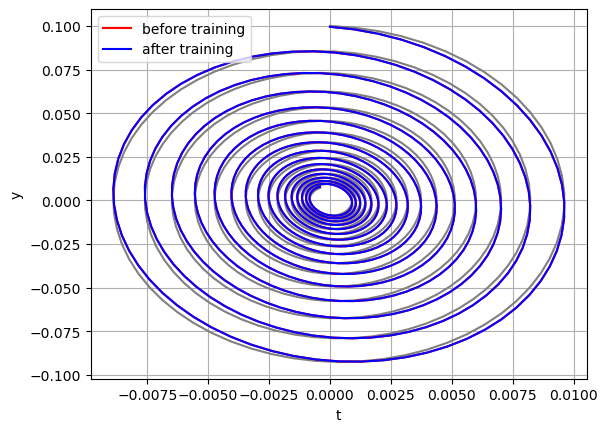

In [36]:
if __name__ == "__main__":
    # masses, spring coefficients, and damping coefficients
    m = np.array([20.0], dtype='float32')
    c = np.array([10.0], dtype='float32')
    k = np.array([2e3], dtype='float32')

    # data
    df = pd.read_csv('./damped_data.csv')
    t  = df[['t']].values
    dt = (t[1] - t[0])[0]
    xtrain = df[['y']].values
    ytrain = df[['ydot']].values

    # initial displacement and velocity
    initial_displacement = np.array([ytrain[0][0]], dtype='float32')
    initial_velocity = np.array([0], dtype='float32')

    # fitting physics-informed neural network
    initial_state = np.concatenate([initial_displacement, initial_velocity])[np.newaxis, :]
    model = create_model(m, c, k, dt, initial_state=initial_state, batch_input_shape=(None, xtrain.shape[0], 1))
    yPred_before = model.predict(xtrain[np.newaxis, :, :])
    model.fit(xtrain[np.newaxis, :, :], ytrain[np.newaxis, :, :], epochs=10, steps_per_epoch=1, verbose=1)
    yPred = model.predict(xtrain[np.newaxis, :, :])

    # plotting prediction results
    plt.plot(xtrain, ytrain[:, 0], 'gray')
    plt.plot(xtrain, yPred_before[0, :, 0], 'r', label='before training')
    plt.plot(xtrain, yPred[0, :, 0], 'b', label='after training')
    plt.xlabel('t')
    plt.ylabel('y')
    plt.grid('on')
    plt.legend()
    plt.show()